### code from Stanford cs229

# Locally weighted linear regression

In [1]:
import math
import matplotlib.pyplot as plt
import numpy as np
import src.util as util

from src.linear_model import LinearModel

In [2]:
x_train, y_train = util.load_dataset('data/ds5_train.csv', add_intercept=True)
x_valid, y_valid = util.load_dataset('data/ds5_valid.csv', add_intercept=True)
x_test, y_test = util.load_dataset('data/ds5_test.csv', add_intercept=True)

Take a look at the training set:

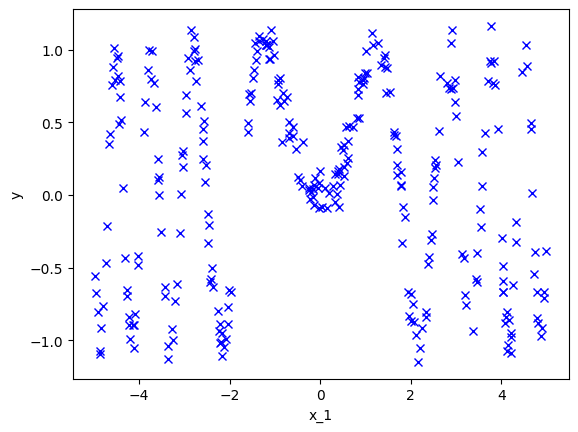

In [3]:
plt.xlabel('x_1')
plt.ylabel('y')
plt.plot(x_train[:,-1], y_train, 'bx', linewidth=2)

In [4]:
x_train.shape, y_train.shape

((300, 2), (300,))

## Implement locally weighted linear regression:

The cost function

\begin{align*}
J(\theta) & = \frac{1}{2} \sum_{i = 1}^{m} w^{(i)} \big( \theta^T x^{(i)} - y^{(i)} \big)^2 \\
          & = (X \theta - y)^T W (X \theta - y)
\end{align*}

Notice that there are only $m$ $w^{(i)}$'s, and $w^{(i)}$ only takes effect on the $i$-th entry of $(X \theta - y)^T$ and $(X \theta - y)$.
Hence, $W$ is a diagonal matrix, and the above equation holds by picking:

\begin{equation}
X = \begin{bmatrix}
     - (x^{(1)})^T - \\
     \vdots \\
     - (x^{(m)})^T - \\
     \end{bmatrix}
     \in \mathbb{R}^{m \times n}
\qquad
y = \begin{bmatrix}
     y^{(1)} \\
     \vdots \\
     y^{(m)} \\
     \end{bmatrix}
\qquad
W = \frac{1}{2} \mathrm{diag} (w^{(i)}, \dots , w^{(m)})
\end{equation}

To simplify the calculation, let $J(\theta) = \frac{1}{2} (X \theta - y)^T W (X \theta - y)$. To minimize $J$, take derivative w.r.t $\theta$ and set to 0:

\begin{align*}
\nabla_\theta J(\theta) & = \nabla_\theta \big( \frac{1}{2} (X \theta - y)^T W (X \theta - y) \big) \\
                        & = \frac{1}{2} \nabla_\theta (\theta^T X^T W X \theta - 2 y^T W X \theta + y^T W y) \\
                        & = \frac{1}{2} \nabla_\theta \big( \theta^T (X^T W X) \theta - 2 (X^T W^T y)^T \theta \big) \\
                        & = \frac{1}{2} (2 X^T W X \theta - 2 X^T W^T y) \\
                        & = X^T W X \theta - X^T W^T y \\
                        & = X^T W X \theta - X^T W y \\
                        & = 0
\end{align*}

By solving the equation, we obtain:

$$\theta = (X^T W X)^{-1} X^T W y$$

In [5]:
class LocallyWeightedLinearRegression(LinearModel):
    """Locally Weighted Regression (LWR).

    Example usage:
        > clf = LocallyWeightedLinearRegression(tau)
        > clf.fit(x_train, y_train)
        > clf.predict(x_eval)
    """

    def __init__(self, tau):
        super(LocallyWeightedLinearRegression, self).__init__()
        self.tau = tau
        self.x = None
        self.y = None

    def fit(self, x, y):
        """Fit LWR by saving the training set.

        :param x: Training example inputs. Shape (m, n).
        :param y: Training example labels. Shape (m,).
        """
        self.x = x
        self.y = y


    def predict(self, x):
        """Make predictions given inputs x.

        :param x: Inputs of shape (m, 2).
        :return:  Outputs of shape (2,).
        """
        # the dimension of weighted matrix is (m,m) 
        m = x.shape[0]
        w = np.zeros([m,m])
        y_predict = np.zeros(m)
        for i in range(m):
            # x.shape is (m,2), np.diag's input must be 1 or 2-d, so need to use np.sum
            w = np.diag(np.exp(np.sum((self.x - x[i])**2, axis=1) / (-2*self.tau**2)))
            # theta.shape is (2,)
            theta = np.linalg.inv(self.x.T @ w @ self.x) @ self.x.T @ w @ self.y
            y_predict[i] = theta.T @ x[i] 
        return y_predict

## Plot predictions on training set and validation set:

In [6]:
clf = LocallyWeightedLinearRegression(tau=0.5)
clf.fit(x_train, y_train)

In [7]:
def plot(x, y_label, y_pred, title):
    plt.figure()
    plt.plot(x[:,-1], y_label, 'bx', label='label')
    plt.plot(x[:,-1], y_pred, 'ro', label='prediction')
    plt.suptitle(title, fontsize=12)
    plt.legend(loc='upper left')

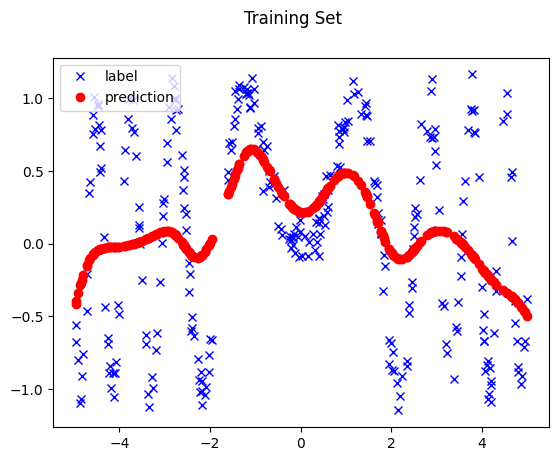

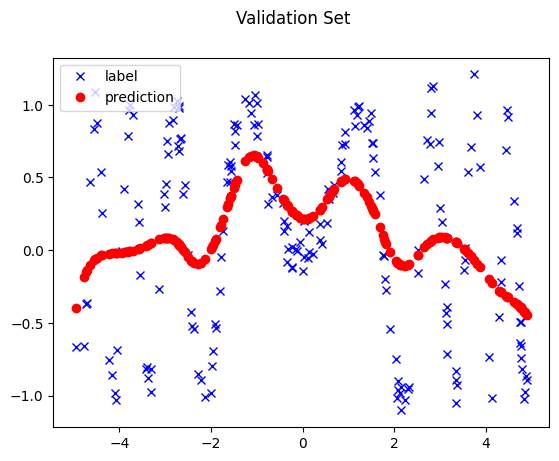

In [8]:
y_train_pred = clf.predict(x_train)
plot(x_train, y_train, y_train_pred, 'Training Set')

y_valid_pred = clf.predict(x_valid)
plot(x_valid, y_valid, y_valid_pred, 'Validation Set')

From the figures, we can see the model is underfitting.

## Try different $\tau$ value

### when $\tau = 0.05$ the result is overfit

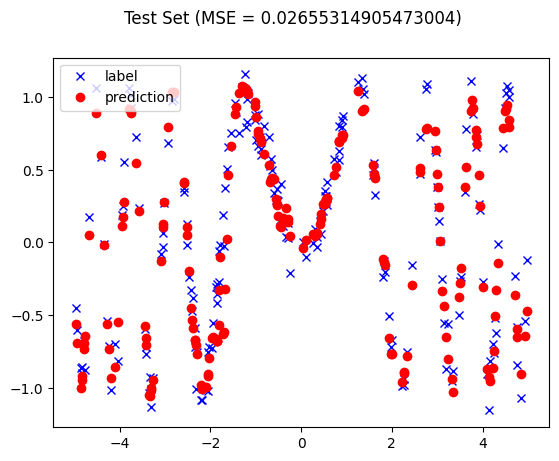

In [9]:
clf = LocallyWeightedLinearRegression(tau=3e-2)
clf.fit(x_train, y_train)
y_test_pred = clf.predict(x_test)

plot(x_test, y_test, y_test_pred, f'Test Set (MSE = {np.mean((y_test_pred - y_test)**2)})')

### when $\tau = 0.05$ the result is reasonable

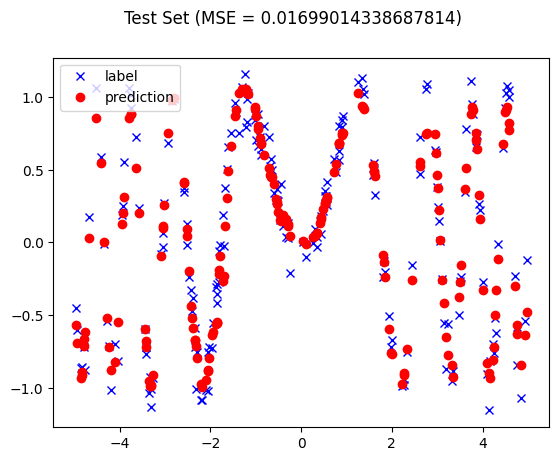

In [10]:
clf = LocallyWeightedLinearRegression(tau=0.05)
clf.fit(x_train, y_train)
y_test_pred = clf.predict(x_test)

plot(x_test, y_test, y_test_pred, f'Test Set (MSE = {np.mean((y_test_pred - y_test)**2)})')

### when $\tau = 1$ the result is underfit

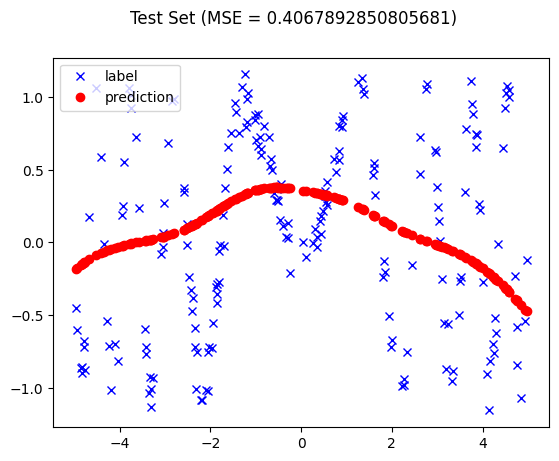

In [11]:
clf = LocallyWeightedLinearRegression(tau=1)
clf.fit(x_train, y_train)
y_test_pred = clf.predict(x_test)

plot(x_test, y_test, y_test_pred, f'Test Set (MSE = {np.mean((y_test_pred - y_test)**2)})')